In [65]:
import pandas as pd
import multiprocessing as mp
import wtfutil as wtf
import pathlib
import datetime as dt
import os
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import pprint

In [66]:
DATE_REF=dt.datetime.utcnow().date() - dt.timedelta(days=1)
PATH_PREFIX=DATE_REF.strftime('data/%Y/%m/%d/')

rawdata = dict()
aggdata = dict()

dfs = dict()

def process(path, buckets=20):
    _, timestamp, _ = path.name.split('_')
    ts = pd.Timestamp(dt.datetime.fromtimestamp(int(timestamp)))
    
    
    df = pq.read_table(path.open('rb'), columns=['satoshi', 'vsize', 'diff']).to_pandas()
#    agg_add = wtf.feeagg(df.query('diff == 1'), buckets=buckets)
#     agg_del = wtf.feeagg(df.query('diff == -1'), buckets=buckets)
#    agg = agg_add
#    agg = wtf.feeagg(df)
#    series = [agg[c].add_prefix(f'{c}-').add_suffix(f'_{buckets}') for c in agg.columns]
#    series = []
#    return (ts, pd.concat(series))

    return (ts, df)

def pr_aggregate(lst): # lst = [(ts, df),...]
    ts = lst[0][0]
    ts.date()
    idx = pd.date_range(ts.date(), periods=144, freq='10T')
    data = [list() for n in range(144)]
    series = []
    
    for ts, df in lst:
        t = ts.time()
        n = int((t.hour * 60 * 60 + t.minute * 60 + t.second)/600)
        data[n].append(df)
    
    for n, dfs in enumerate(data):
        scalar = 40/len(dfs)
        df_concat = pd.concat(dfs).query('diff == 1')
        series.append(wtf.feeagg(df_concat).stack() * scalar)
    
    return pd.DataFrame(series, index=idx).swaplevel(axis=1)



def mp_load(date_ref, use_cache=True):
    if not date_ref in rawdata:
        with mp.Pool(16) as p:
            path_prefix = date_ref.strftime('data/%Y/%m/%d/')
            it_paths = pathlib.Path(path_prefix).glob('*_diff.parq')
            rawdata[date_ref] = p.map(process, it_paths)

    return rawdata[date_ref]
    


KeyError: 0

In [67]:
%%time

# load it into memory (may take 60 seconds)
for i in range(28):
    date_now = dt.datetime.utcnow().date()
    date_ref = date_now - dt.timedelta(days=i+1)
    mp_load(date_ref)
    



CPU times: user 37.7 s, sys: 7.1 s, total: 44.8 s
Wall time: 51.2 s


In [68]:
%%time

with mp.Pool(16) as p:
    aggdata = p.map(pr_aggregate, rawdata.values())


CPU times: user 17.1 s, sys: 544 ms, total: 17.7 s
Wall time: 21.4 s


In [69]:
def draw(df):
    fig = plt.figure(figsize=(16,2), dpi=72)
    title = df.index[0].strftime('%Y-%m-%d (%A)')
    ax = plt.subplot(111)
    ax.set_ylim([0,1])
    pdf = df['mvs'][list(range(19,0,-1))]
    pdf = pdf.resample('30T', convention='s').sum()/3
    pdf.plot(
        kind='area', 
        stacked=True,
        colormap='tab20b_r', 
        ax=ax, 
        legend=False, 
        title=title
    )
    plt.show()

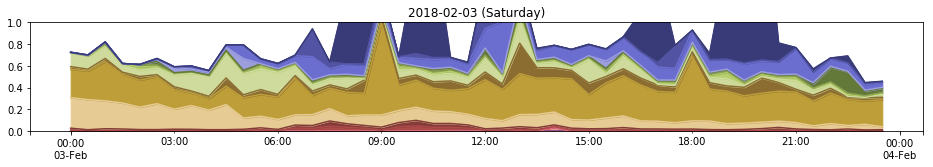

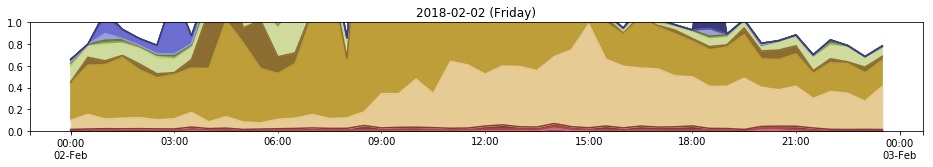

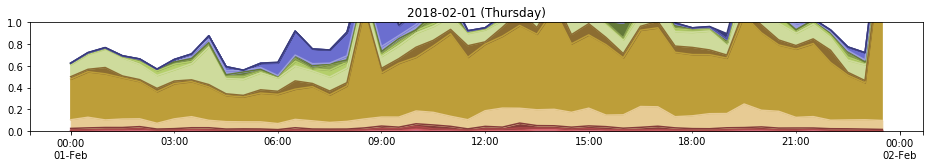

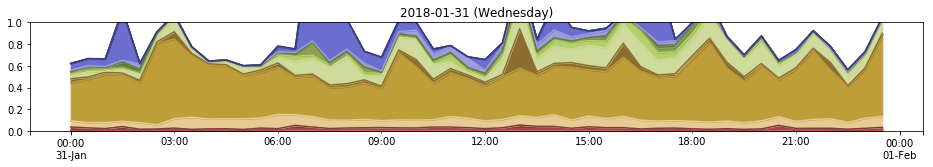

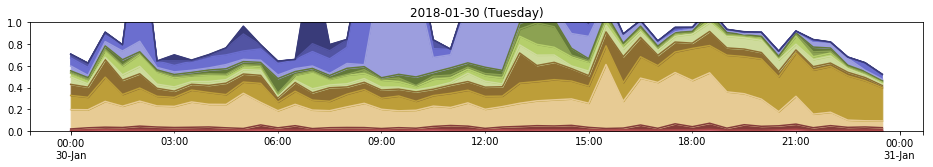

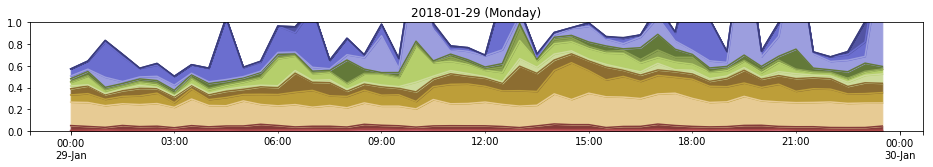

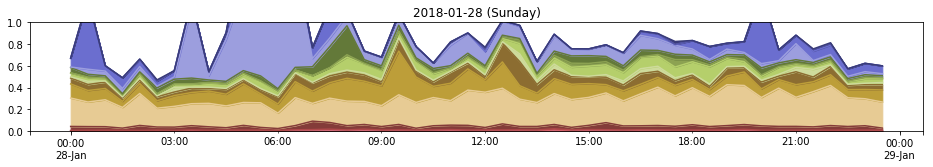

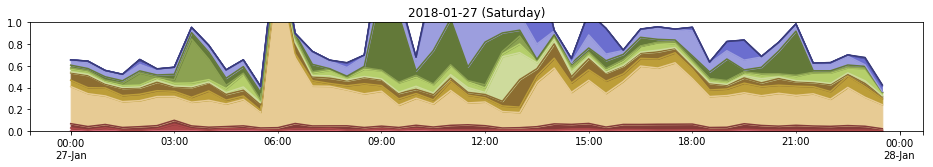

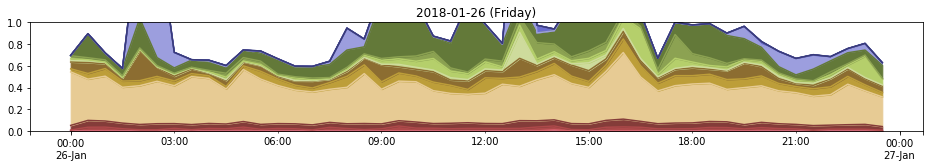

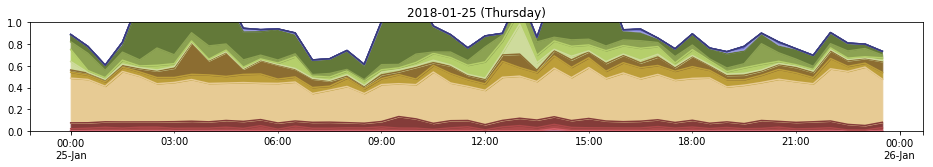

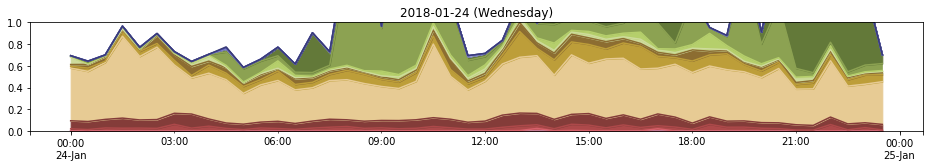

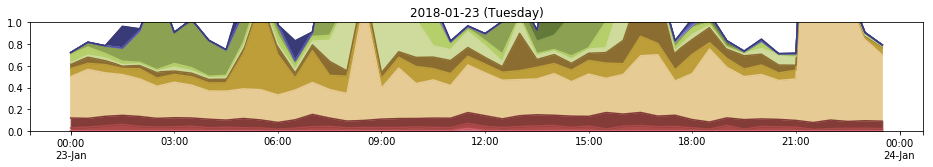

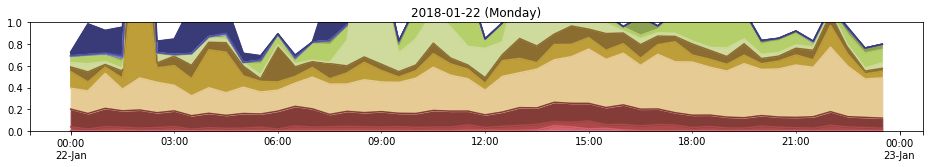

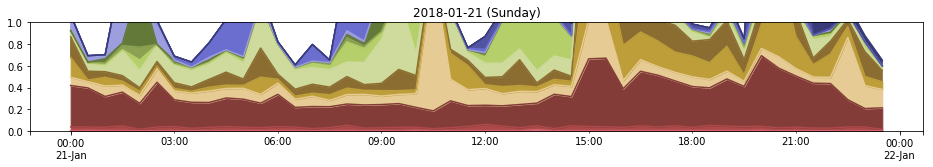

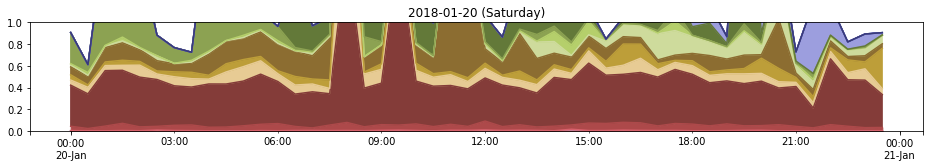

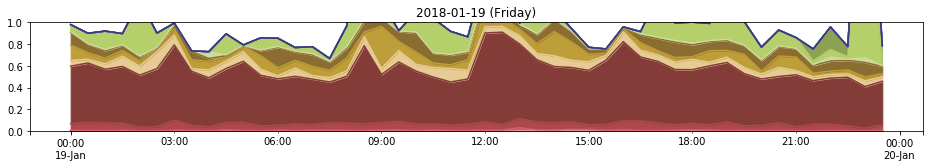

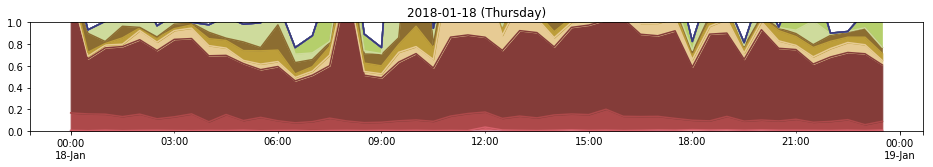

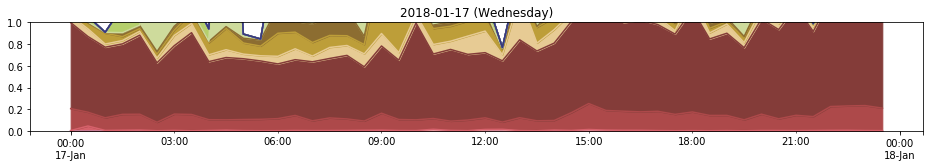

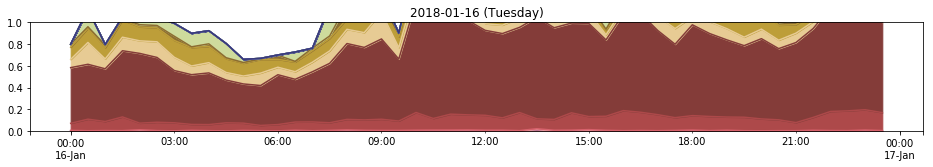

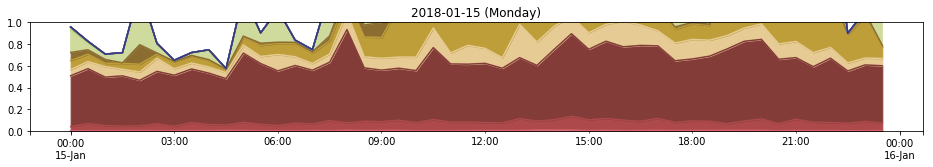

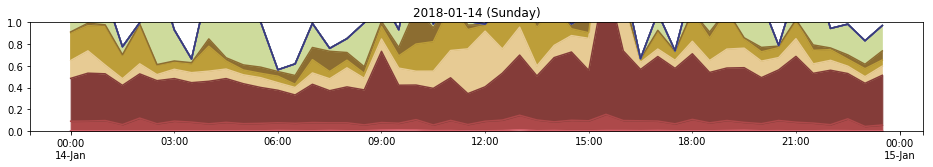

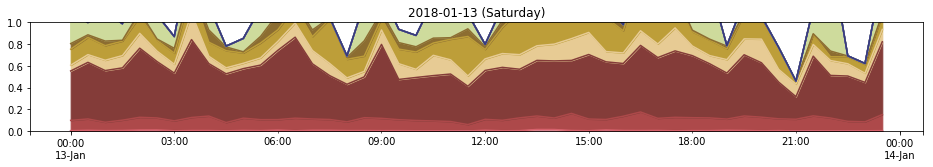

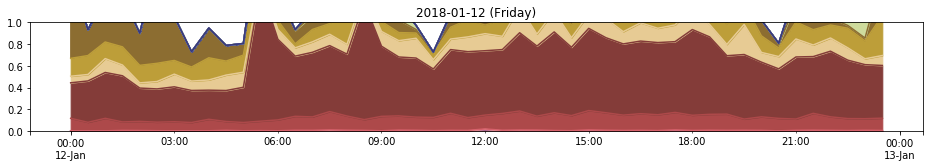

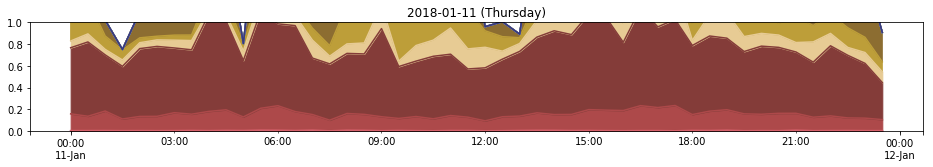

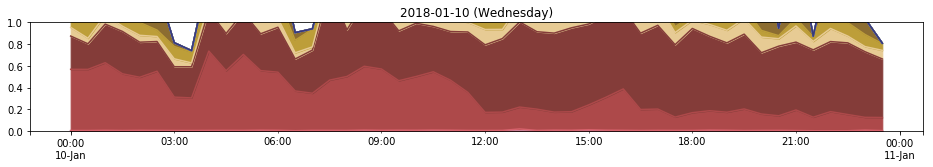

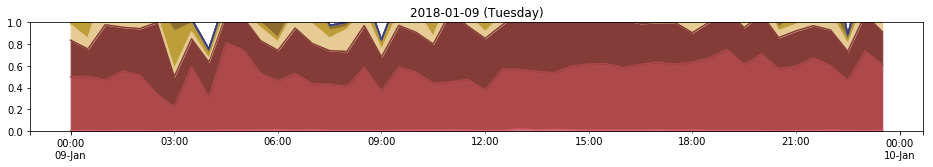

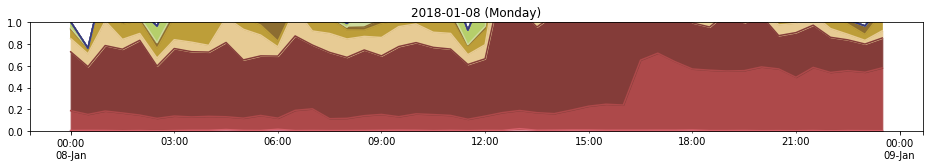

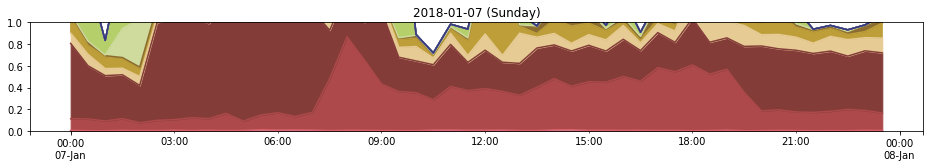

In [70]:
for i in range(28):
    draw(aggdata[i])

In [642]:
%%time

for i in range(3):
    date_ref = datetime.datetime.utcnow().date() - datetime.timedelta(days=1) - datetime.timedelta(days=i)
    res = mp_load(date_ref)
    ts = res[0][0]
    empty_df = pd.DataFrame(index=pd.date_range(ts.date(), periods=60*60*24/15, freq='15S'))
    partial_df = pd.DataFrame.from_items(res).T
    full_df = pd.concat([empty_df, partial_df], axis=1)
    
    title = date_ref.strftime('%Y-%m-%d (%A)')
    resampled_df = full_df.resample('20T', convention='s').sum()/2
    fig = plt.figure(figsize=(16,2), dpi=72)
    ax = plt.subplot(111)
    ax.set_ylim([0,2.5])
    cols = list(filter(lambda x: x.startswith('mvs'), resampled_df.columns))[::-1]
    resampled_df = pd.np.maximum(resampled_df, 0)

    resampled_df[cols].plot(kind='area', stacked=True, colormap='tab20b_r', ax=ax, legend=False, title=title)

    plt.show()


ValueError: If using all scalar values, you must pass an index

In [485]:
pd.np.maximum(pd.Series(pd.np.random.rand(20)-.5),0)

0     0.000000
1     0.464615
2     0.000000
3     0.215833
4     0.000000
5     0.000000
6     0.473047
7     0.332757
8     0.000000
9     0.153086
10    0.254501
11    0.000000
12    0.069107
13    0.000000
14    0.432855
15    0.000000
16    0.000000
17    0.365489
18    0.131390
19    0.000000
dtype: float64